# Tech Challenger - Etapa 2: Construção do Modelo
Como profissional responsável pelo desenvolvimento de um modelo preditivo de regressão para estimar os custos médicos individuais cobrados por seguros de saúde, utilizamos o conjunto de dados [Medical Cost Personal Datasets](https://www.kaggle.com/datasets/mirichoi0218/insurance/data) para validar hipóteses relacionadas aos fatores que impactam a definição dos custos dos planos de saúde.


## Objetivo

Construir um modelo preditivo para os custos médicos baseado nas analises e processamentos verificados na etapa anterior. Vamos coletar o que deu o melhor resultado e criar um modelo que pode ser utilizavel em uma aplicação real.

### Compilando a leitura e processamento da etapa anterior

Unificando o que foi explicado na etapa anterior em um código limp para apenas processar os dados.

In [19]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
data = pd.read_csv("dados/insurance.csv")
data = data.drop(['region'], axis='columns') # A Coluna Região não é relevante para o modelo
data = data.drop(['sex'], axis='columns') # A Coluna Sexo não é relevante para o modelo
data.head()

,age,bmi,children,smoker,charges
0,19,27.900,0,yes,16884.92400
1,18,33.770,1,no,1725.55230
2,28,33.000,3,no,4449.46200
3,33,22.705,0,no,21984.47061
4,32,28.880,0,no,3866.85520


In [21]:
data["weight_condition"] = ""
for col in [data]:
    col.loc[col["bmi"] < 18.5, "weight_condition"] = "Underweight"
    col.loc[(col["bmi"] >= 18.5) & (col["bmi"] < 24.986), "weight_condition"] = "Normal Weight"
    col.loc[(col["bmi"] >= 25) & (col["bmi"] < 29.926), "weight_condition"] = "Overweight"
    col.loc[col["bmi"] >= 30, "weight_condition"] = "Obese"

In [22]:
# Preparando os dados
numeric_columns = [ 'age', 'bmi', 'children'] # Colunas numéricas
categorical_columns = [ 'smoker', 'weight_condition']


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns), # numeric features
        ('cat', OneHotEncoder(), categorical_columns) # categorical features
    ])


base_transformed = preprocessor.fit_transform(data)
base_transformed_df = pd.DataFrame(base_transformed, columns=preprocessor.get_feature_names_out())
data = pd.concat([data['charges'], base_transformed_df], axis=1)
data.head()

,charges,num__age,num__bmi,num__children,cat__smoker_no,cat__smoker_yes,cat__weight_condition_Normal Weight,cat__weight_condition_Obese,cat__weight_condition_Overweight,cat__weight_condition_Underweight
0,16884.92400,-1.438764,-0.453320,-0.908614,0.0,1.0,0.0,0.0,1.0,0.0
1,1725.55230,-1.509965,0.509621,-0.078767,1.0,0.0,0.0,1.0,0.0,0.0
2,4449.46200,-0.797954,0.383307,1.580926,1.0,0.0,0.0,1.0,0.0,0.0
3,21984.47061,-0.441948,-1.305531,-0.908614,1.0,0.0,1.0,0.0,0.0,0.0
4,3866.85520,-0.513149,-0.292556,-0.908614,1.0,0.0,0.0,0.0,1.0,0.0


### Construção do Modelo

Nessa etapa vamos dividir os dados de teste e treinamento e escolher os modelos que podemos utilizar para previsão.

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [24]:
X = data.drop(['charges'], axis=1)
y = data['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Como avaliar o que está bom ou ruim:
* MSE e MAE:
    * Compare os valores entre os modelos. O modelo com os menores valores de MSE e MAE é o mais preciso.
    * Se os valores forem muito altos, o modelo pode estar subajustado (underfitting).
* R²:
    * Um valor próximo de 1 é desejável.
    * Se o R² for muito baixo, o modelo pode não estar capturando bem os padrões dos dados.
    * Se for muito alto, verifique se o modelo não está superajustado (overfitting).
* QQ Plot:
    * Resíduos alinhados indicam que o modelo está atendendo à suposição de normalidade.
    * Se houver desvios, considere ajustar o modelo ou revisar os dados.
* MAPE:
    * A expressão do erro absoluto médio como percentual
    * Com ele vamos entender a precisão do modelo com relação ao valores reais.

### Selecionando alguns modelos e verificando o desempenho

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sns.set_theme(style="whitegrid")


Primeiro vamos preparar algumas funções para avaliar os modelos.

In [26]:

# Função para calcular o MAPE (Mean Absolute Percentage Error)
# O MAPE é uma métrica que expressa o erro absoluto médio como uma porcentagem dos valores reais
# É útil para entender a precisão do modelo em relação aos valores reais
# O MAPE é calculado como a média dos erros absolutos relativos, multiplicada por 100
def calculate_mape(labels, predictions):
    errors = np.abs(labels - predictions)
    relative_errors = errors / np.abs(labels)
    mape = np.mean(relative_errors) * 100
    return mape


In [27]:

# Função para avaliar o modelo
# A função avalia o desempenho do modelo em termos de erro absoluto médio (MAE), erro quadrático médio (MSE),
# raiz do erro quadrático médio (RMSE), MAPE e R²
# O MAE mede a média das diferenças absolutas entre os valores reais e previstos
# O MSE mede a média dos quadrados das diferenças entre os valores reais e previstos
# O RMSE é a raiz quadrada do MSE e fornece uma medida da magnitude do erro
# O MAPE mede o erro absoluto médio como uma porcentagem dos valores reais
# O R² mede a proporção da variância dos dados que é explicada pelo modelo
# O R² varia de 0 a 1, onde 1 indica que o modelo explica toda a variância dos dados
def evaluate_model(model, y_test, y_pred):
    print(f"\n{'='*100}")
    print(f"Avaliação do Modelo: {model}")
    print(f"{'='*100}")
    print("* Erro Absoluto Médio (MAE):", round(mean_absolute_error(y_test, y_pred), 2))
    print("* Erro Quadrático Médio (MSE):", round(mean_squared_error(y_test, y_pred), 2))
    print("* Raiz do Erro Quadrático Médio (RMSE):", round(np.sqrt(mean_squared_error(y_test, y_pred)), 2))
    print("* MAPE:", round(calculate_mape(y_test, y_pred), 2), "%")
    print("* R²:", round(r2_score(y_test, y_pred), 4))


In [28]:

# Função para plotar os resíduos
# A função plota um gráfico de dispersão dos valores reais em relação aos valores previstos
# e adiciona uma linha de referência (linha de identidade) que representa os valores reais iguais aos valores previstos
# O gráfico ajuda a visualizar a distribuição dos erros do modelo
# Se os pontos estiverem próximos da linha de identidade, significa que o modelo está fazendo previsões precisas
# Se os pontos estiverem dispersos longe da linha, significa que o modelo está cometendo erros significativos
def plot_residuals(model, y_test, y_pred): 
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test, y=y_pred, color='seagreen', alpha=0.6, s=60)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
    plt.title(f'Valores Reais vs Valores Previsto | {model.__class__.__name__}', fontsize=14, weight='bold')
    plt.xlabel('Valores Reais', fontsize=12)
    plt.ylabel('Valores Previsto', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


In [29]:
# Função para treinar o modelo e fazer previsões
# A função treina o modelo com os dados de treinamento e faz previsões nos dados de teste
# Em seguida, ela plota os resíduos e avalia o desempenho do modelo
def predict_and_evaluate(model, X_test, X_train, y_test, y_train):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    plot_residuals(model, y_test, y_pred)
    evaluate_model(model, y_test, y_pred)


Agora iremos avaliar 4 modelos de regressão.

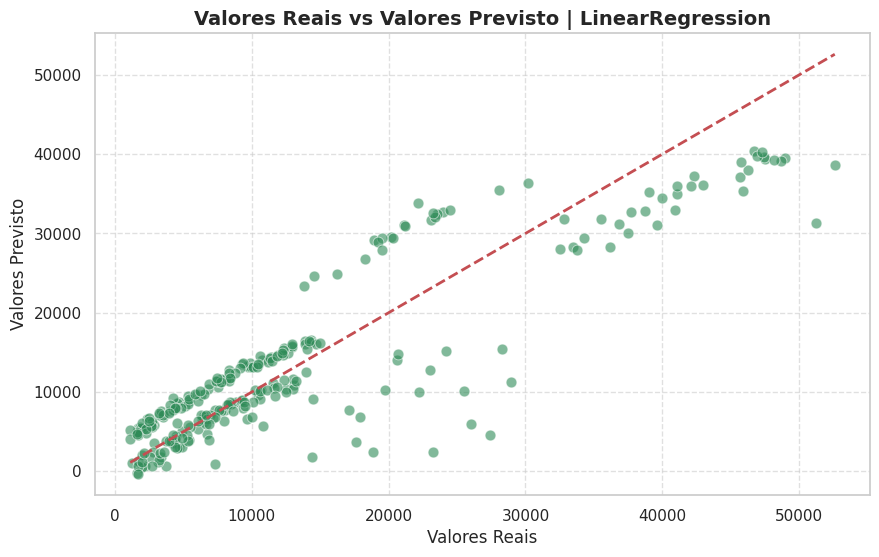


Avaliação do Modelo: LinearRegression()
* Erro Absoluto Médio (MAE): 4101.8
* Erro Quadrático Médio (MSE): 32288223.85
* Raiz do Erro Quadrático Médio (RMSE): 5682.27
* MAPE: 45.22 %
* R²: 0.7971


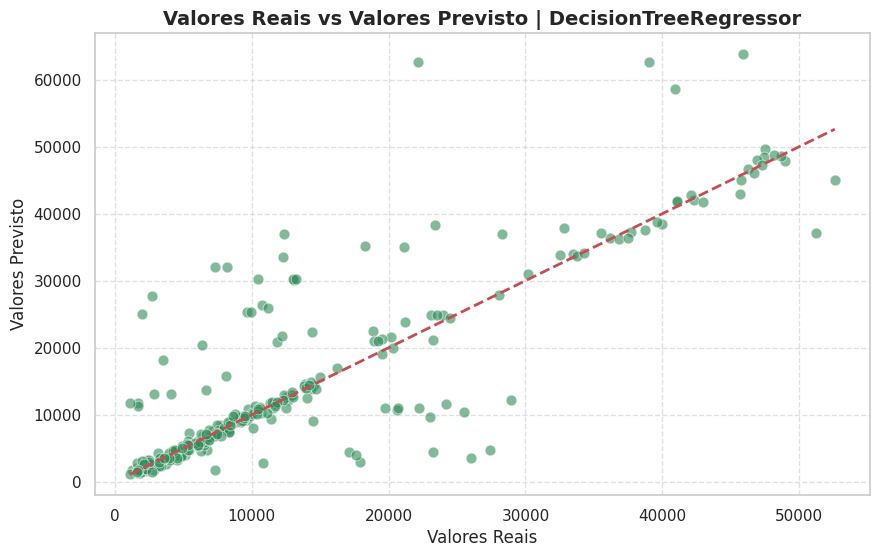


Avaliação do Modelo: DecisionTreeRegressor(random_state=42)
* Erro Absoluto Médio (MAE): 3444.73
* Erro Quadrático Médio (MSE): 52949822.66
* Raiz do Erro Quadrático Médio (RMSE): 7276.66
* MAPE: 42.84 %
* R²: 0.6673


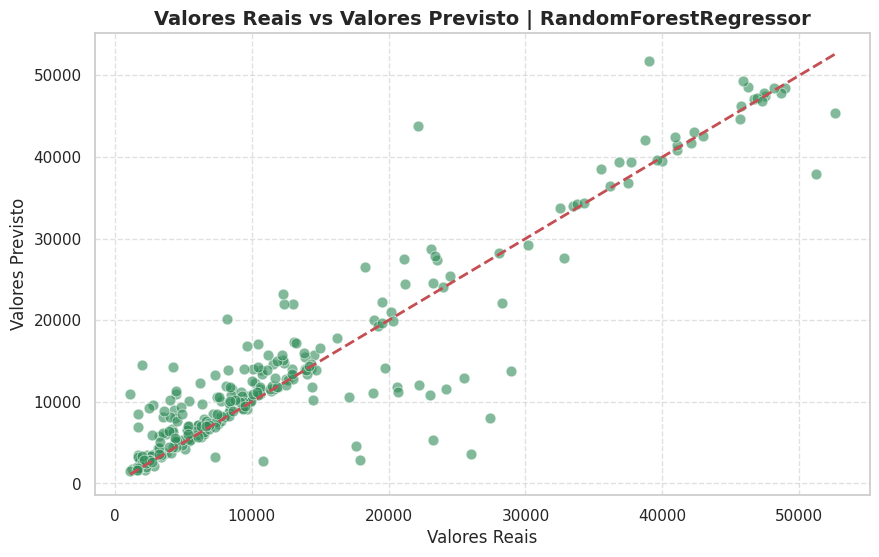


Avaliação do Modelo: RandomForestRegressor(random_state=42)
* Erro Absoluto Médio (MAE): 2654.31
* Erro Quadrático Médio (MSE): 21710889.97
* Raiz do Erro Quadrático Médio (RMSE): 4659.49
* MAPE: 36.02 %
* R²: 0.8636


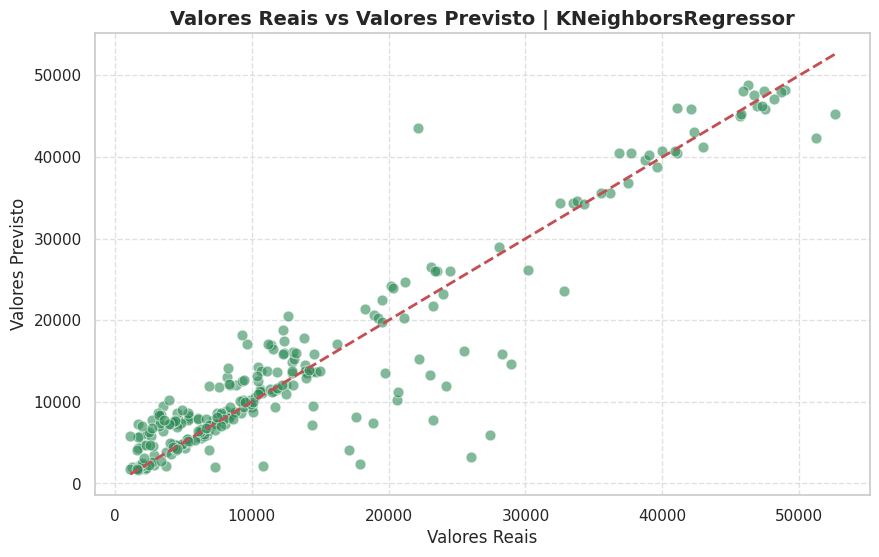


Avaliação do Modelo: KNeighborsRegressor()
* Erro Absoluto Médio (MAE): 2628.36
* Erro Quadrático Médio (MSE): 19487061.31
* Raiz do Erro Quadrático Médio (RMSE): 4414.42
* MAPE: 35.23 %
* R²: 0.8775


In [30]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

models = [
    LinearRegression(), 
    DecisionTreeRegressor(random_state=42), 
    RandomForestRegressor(n_estimators=100, random_state=42),
    KNeighborsRegressor(n_neighbors=5)
]

for model in models:
    predict_and_evaluate(model, X_test, X_train, y_test, y_train)


Dentre os modelos, o RandomForestRegressor foi o que mais apresentou acerto. Podemos trabalhar com os hiperparametros dele e buscar algo que faça uma metrica boa e com uma taxa de erros baixa.

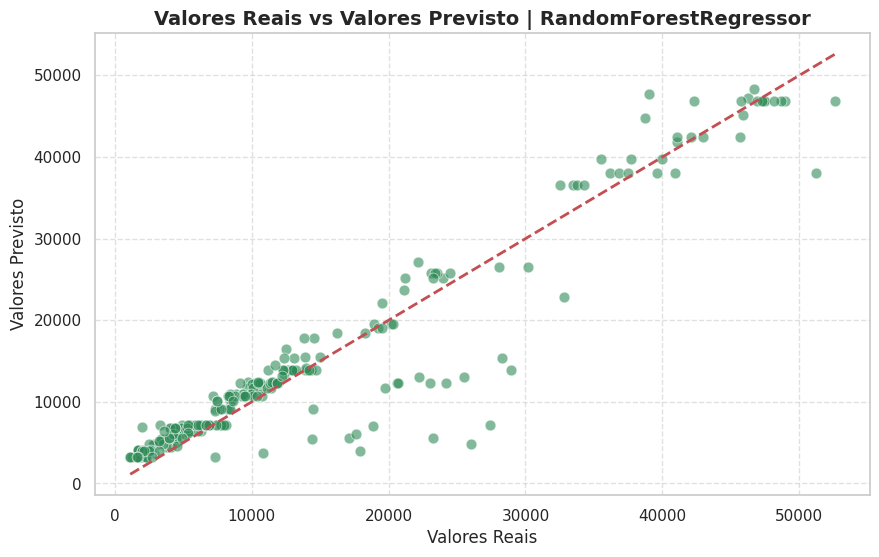


Avaliação do Modelo: RandomForestRegressor(criterion='friedman_mse', max_depth=20, max_leaf_nodes=17,
                      n_estimators=7, random_state=1)
* Erro Absoluto Médio (MAE): 2393.72
* Erro Quadrático Médio (MSE): 15811264.73
* Raiz do Erro Quadrático Médio (RMSE): 3976.34
* MAPE: 30.37 %
* R²: 0.9006


In [31]:
model = RandomForestRegressor(n_estimators=7, max_depth=20, max_leaf_nodes=17, criterion = 'friedman_mse', random_state = 1)
predict_and_evaluate(model, X_test, X_train, y_test, y_train)

Monstrando os atributos que tem relevancia para o modelo

O gráfico SHAP apresenta a contribuição de cada variável na previsão dos custos médicos, destacando como cada feature impacta positiva ou negativamente o resultado do modelo.

**Como interpretar o gráfico:**
- **Eixo Y:** Lista das variáveis, ordenadas da mais impactante (topo) para a menos relevante (base).
- **Eixo X:** Mostra o valor SHAP, ou seja, o **impacto da variável na previsão**:
  - Valores positivos → **aumentam** o custo previsto.
  - Valores negativos → **diminuem** o custo previsto.
- **Cada ponto:** Representa um registro da base de dados:
  - **Azul:** Valor baixo da variável.
  - **Rosa/vermelho:** Valor alto da variável.

Using 1070 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 50/50 [00:03<00:00, 13.89it/s]


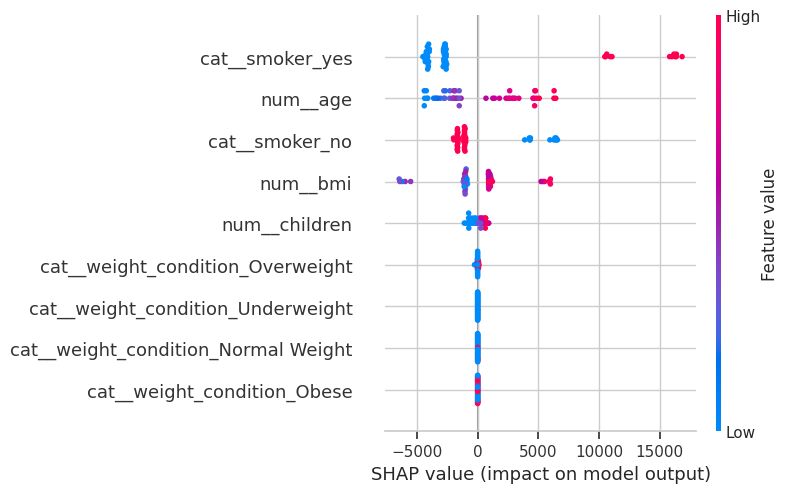

In [32]:
import shap
# Cria o explainer com uma função que faz a predição
explainer = shap.KernelExplainer(model.predict, X_train)
# Calcula os valores SHAP para um subconjunto dos dados
shap_values = explainer.shap_values(X_test[:50])
# Plot do impacto das variáveis
shap.summary_plot(shap_values, X_test[:50])

In [33]:
import eli5
colunas = preprocessor.get_feature_names_out()
eli5.show_weights(model, feature_names = colunas)

Weight,Feature
0.4869 ± 0.6175,cat__smoker_yes
0.1899 ± 0.6004,cat__smoker_no
0.1892 ± 0.0286,num__bmi
0.1247 ± 0.0211,num__age
0.0091 ± 0.0055,num__children
0.0003 ± 0.0013,cat__weight_condition_Overweight
0 ± 0.0000,cat__weight_condition_Underweight
0 ± 0.0000,cat__weight_condition_Normal Weight
0 ± 0.0000,cat__weight_condition_Obese


Agora que sabemos qual modelo escolher e as metricas estão boas, vamos criar um pipeline que irá modificar os dados de entrada e processar o modelo para realizar as predições. O Pipeline ficara em um arquivo para ser carregado por outra aplicação desejada (um serviço, biblioteca, ...)

In [34]:
import pickle
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

class WeightConditionTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X["weight_condition"] = ""
        X.loc[X["bmi"] < 18.5, "weight_condition"] = "Underweight"
        X.loc[(X["bmi"] >= 18.5) & (X["bmi"] < 25), "weight_condition"] = "Normal Weight"
        X.loc[(X["bmi"] >= 25) & (X["bmi"] < 30), "weight_condition"] = "Overweight"
        X.loc[X["bmi"] >= 30, "weight_condition"] = "Obese"
        return X

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), ['age', 'bmi', 'children']), # numeric features
    ('cat', OneHotEncoder(), ['smoker', "weight_condition"]) # categorical features
])

pipeline = Pipeline(steps=[
    ('add_weight_condition', WeightConditionTransformer()), # Adiciona a coluna weight_condition
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=7, max_depth=20, max_leaf_nodes=17, criterion = 'friedman_mse', random_state = 1))
])

data = pd.read_csv("dados/insurance.csv")
data = data.drop(['region'], axis='columns')  # A Coluna Região não é relevante para o modelo
data = data.drop(['sex'], axis='columns')  # A Coluna Sexo não é relevante para o modelo


X = data.drop(['charges'], axis=1)
y = data['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
pipeline.fit(X_train, y_train)

with open('wcmodel.pkl', 'wb') as f:
    pickle.dump(pipeline, f)
    
pipeline

Pipeline(steps=[('add_weight_condition', WeightConditionTransformer()),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat', OneHotEncoder(),
                                                  ['smoker',
                                                   'weight_condition'])])),
                ('model',
                 RandomForestRegressor(criterion='friedman_mse', max_depth=20,
                                       max_leaf_nodes=17, n_estimators=7,
                                       random_state=1))])

In [35]:
features = pd.DataFrame([['no', 33,25, 0]], columns=['smoker', 'age', 'bmi', 'children'])
result = pipeline.predict(features)
print(f"Predicted insurance cost: {result}")

Predicted insurance cost: [6172.02456359]


In [36]:
import os
from pydantic import BaseModel


class InsuranceData(BaseModel):
    smoker: str
    age: int
    bmi: float
    children: int
    

class WealthCostPrediction:
    
    def __init__(self):
        self.model_path = 'wcmodel.pkl'
        self.pipeline = None
        
    def predict(self, features):
        if not os.path.exists(self.model_path):
            raise FileNotFoundError(f"Model file '{self.model_path}' not found. Please train the model first.")
        
        with open(self.model_path, 'rb') as f:
            self.pipeline = pickle.load(f)
        
        if not isinstance(features, pd.DataFrame):
            features = pd.DataFrame([features], columns=['smoker', 'age', 'bmi', 'children'])
        
        prediction = self.pipeline.predict(features)
        return round(float(prediction[0]), 2)
        


features = InsuranceData(smoker='no', age=33, bmi=25, children=0)


prediction = WealthCostPrediction()
result = prediction.predict([features.smoker, features.age, features.bmi, features.children])
print(f"Predicted insurance cost: {result}")


Predicted insurance cost: 6172.02
